# Getting Started - RocketPy in Colab

We start by setting up our environment. To run this notebook, we will need:


*   RocketPy
*   netCDF4 (to get weather forecasts)
*   Data files (we will clone RocketPy's repository for these)

Therefore, let's run the following lines of code:

In [1]:
!pip install rocketpy==1.0.1 netCDF4==1.6.4

Now we can start!

Here we go through a simplified rocket trajectory simulation to get you started. Let's start by importing the rocketpy module.

In [2]:
from rocketpy import Environment, SolidMotor, Rocket, Flight
import os

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.

In [3]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

For this and the rest of the tutorial, to check the parameters, methods or just any information about an object (e.g. the environment class) you can just type the following command.

In [4]:
help(Environment)

Help on class Environment in module rocketpy.environment.environment:

class Environment(builtins.object)
 |  Environment(gravity=None, date=None, latitude=0, longitude=0, elevation=0, datum='SIRGAS2000', timezone='UTC')
 |  
 |  Keeps all environment information stored, such as wind and temperature
 |  conditions, as well as gravity.
 |  
 |  Attributes
 |  ----------
 |  Environment.earth_radius : float
 |      Value of Earth's Radius as 6.3781e6 m.
 |  Environment.air_gas_constant : float
 |      Value of Air's Gas Constant as 287.05287 J/K/Kg
 |  Environment.gravity : float
 |      Positive value of gravitational acceleration in m/s^2.
 |  Environment.latitude : float
 |      Launch site latitude.
 |  Environment.longitude : float
 |      Launch site longitude.
 |  Environment.datum : string
 |      The desired reference ellipsoid model, the following options are
 |      available: "SAD69", "WGS84", "NAD83", and "SIRGAS2000". The default
 |      is "SIRGAS2000", then this model wil

## Setting Up a Simulation

### Creating an Environment for Fairlie Moor

In [5]:
Env = Environment(latitude=55.7268113, longitude=-4.8109188, elevation=243)


To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.

In [6]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

Then, we tell Env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.

In [7]:
Env.set_atmospheric_model(type="Forecast", file="GFS")

We can see what the weather will look like by calling the info method!


Gravity Details

Acceleration of Gravity at Lauch Site: 9.815414812016618 m/s²


Launch Site Details

Launch Date: 2023-10-13 12:00:00 UTC
Launch Site Latitude: 55.72681°
Launch Site Longitude: -4.81092°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 386268.46 W    6177160.55 N
Launch Site UTM zone: 30U
Launch Site Surface Elevation: 88.9 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 78.077 km
Forecast Time Period: From  2023-10-12 06:00:00  to  2023-10-28 06:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 13.13 m/s
Surface Wind Direction: 286.33°
Surface Wind Heading: 106.33°
Surface Pressure: 985.40 hPa
Surface Temperature: 283.05 K
Surface Air Density: 1.213 kg/m³
Surface Speed of Sound: 337.27 m/s


Atmospheric Model Plots



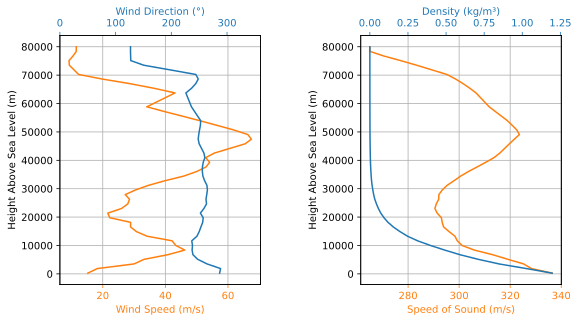

In [8]:
Env.info()

### Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

# Motor

In [9]:
Pro75M1315 = SolidMotor(
    thrust_source="Data/AeroTech_M1315W.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    center_of_dry_mass_position=0.317,
    grains_center_of_mass_position=0.397,
    burn_time=5.4,
    grain_number=5,
    grain_separation=1.588 / 1000,
    grain_density=1815,
    grain_outer_radius=34.63 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=129.997 / 1000,
    nozzle_radius=23.8125 / 1000,
    throat_radius=8.699 / 1000,
    interpolation_method="linear",
)

To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the allInfo method if you want more information all at once!

Nozzle Details
Nozzle Radius: 0.0238125 m
Nozzle Throat Radius: 0.008699 m

Grain Details
Number of Grains: 5
Grain Spacing: 0.001588 m
Grain Density: 1815 kg/m3
Grain Outer Radius: 0.03463 m
Grain Inner Radius: 0.015 m
Grain Height: 0.129997 m
Grain Volume: 0.000 m3
Grain Mass: 0.722 kg

Motor Details
Total Burning Time: 5.4 s
Total Propellant Mass: 3.611 kg
Average Propellant Exhaust Velocity: 1826.660 m/s
Average Thrust: 1221.401 N
Maximum Thrust: 1728.683 N at 0.116 s after ignition.
Total Impulse: 6595.566 Ns



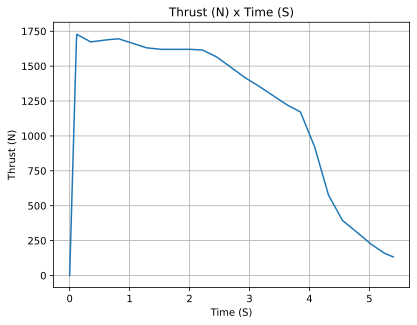

In [10]:
Pro75M1315.info()

### Creating a Rocket

A rocket is composed of several components. Namely, we must have a motor (good thing we have the Pro75M1670 ready), a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes (if we are not launching a missile).

Let's start by initializing our rocket, named Saltire, supplying it with the Pro75M1670 engine, entering its inertia properties, some dimensions and also its drag curves.

In [11]:
Saltire = Rocket(
    radius=127 / 2000,
    mass=17.280 - 5.645,
    inertia=[4.78,4.78,0.13],
    center_of_mass_without_motor = 0,
    power_off_drag="Data/CD Power Off RAS AERO1.csv",
    power_on_drag="Data/CD Power On RAS AERO1.csv",
)

Saltire.set_rail_buttons(0.2, -0.5)
Saltire.add_motor(Pro75M1315, position=-1.255)

#### Adding Aerodynamic Surfaces

Now we define the aerodynamic surfaces. They are really straight forward.

In [12]:
NoseCone = Saltire.add_nose(length=0.6985, kind="vonKarman", position=0.892)

FinSet = Saltire.add_trapezoidal_fins(
    n=4,
    root_chord=0.14,
    tip_chord=0.075,
    span=0.265,
    position=-0.37,
    cant_angle=0,
    radius=None,
    airfoil=None,
)

Tail = Saltire.add_tail(
    top_radius=0.1397, bottom_radius=0.0635, length=0.160, position=-0.61
)

#### Adding Parachutes

Finally, we have parachutes! Saltire will have two parachutes, Drogue and Main.

Both parachutes are activated by some special algorithm, which is usually really complex and a trade secret. Most algorithms are based on pressure sampling only, while some also use acceleration info.

RocketPy allows you to define a trigger function which will decide when to activate the ejection event for each parachute. This trigger function is supplied with pressure measurement at a predefined sampling rate. This pressure signal is usually noisy, so artificial noise parameters can be given. Call help(Rocket.addParachute) for more details. Furthermore, the trigger function also receives the complete state vector of the rocket, allowing us to use velocity, acceleration or even attitude to decide when the parachute event should be triggered.

Here, we define our trigger functions rather simply using Python. However, you can call the exact code which will fly inside your rocket as well.

In [13]:
def drogueTrigger(p, h, y):
    # p = pressure
    # h = height above ground level
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s which will occure at apogee.
    return True if y[5] < 0 else False


def mainTrigger(p, h, y):
    # p = pressure
    # h = height above ground level
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when -45 m/s < vz < -23 m/s and z < 450 + 88.9 m (+110 due to rough surface elevation of ponte del sol, 88.9 m for Fairly moor).
    return True if y[5] > -45 and y[5] < -23 and y[2] < 450 + 88.9 else False

In [14]:
Main = Saltire.add_parachute(
    "Main",
    cd_s=2.20 * 1.4363, #Cd * S (Cd = 2.2, S=(D/4)*pi = 1.8288 pi/4)
    trigger=mainTrigger,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = Saltire.add_parachute(
    "Drogue",
    cd_s=1.5 * 0.2593, #Cd * S (Cd = 1.5, S=(D/4)*pi = 0.3302pi/4)
    trigger=drogueTrigger,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Just be careful if you run this last cell multiple times! If you do so, your rocket will end up with lots of parachutes which activate together, which may cause problems during the flight simulation. We advise you to re-run all cells which define our rocket before running this, preventing unwanted old parachutes. Alternatively, you can run the following lines to remove parachutes(Not found the code yet lol).


In [15]:
help(Rocket)

Help on class Rocket in module rocketpy.rocket.rocket:

class Rocket(builtins.object)
 |  Rocket(radius, mass, inertia, power_off_drag, power_on_drag, center_of_mass_without_motor, coordinate_system_orientation='tail_to_nose')
 |  
 |  Keeps rocket information.
 |  
 |  Attributes
 |  ----------
 |  Rocket.radius : float
 |      Rocket's largest radius in meters.
 |  Rocket.area : float
 |      Rocket's circular cross section largest frontal area in squared
 |      meters.
 |  Rocket.center_of_dry_mass_position : float
 |      Position, in m, of the rocket's center of dry mass (i.e. center of
 |      mass without propellant) relative to the rocket's coordinate system.
 |      See :doc:`Positions and Coordinate Systems </user/positions>`
 |      for more information
 |      regarding the rocket's coordinate system.
 |  Rocket.coordinate_system_orientation : string
 |      String defining the orientation of the rocket's coordinate system.
 |      The coordinate system is defined by the r

## Simulating a Flight

Simulating a flight trajectory is as simple as initializing a Flight class object givin the rocket and environnement set up above as inputs. The launch rail inclination and heading are also given here.

In [16]:
TestFlight = Flight(rocket=Saltire, environment=Env, rail_length=3, inclination=85, heading=0)

## Analyzing the Results

RocketPy gives you many plots, thats for sure! They are divided into sections to keep them organized. Alternatively, see the Flight class documentation to see how to get plots for specific variables only, instead of all of them at once.


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 88.95 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: -3.70 m/s
Lateral Surface Wind Speed: -12.59 m/s


Launch Rail

Launch Rail Length: 3  m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.245 s
Rail Departure Velocity: 16.560 m/s
Rail Departure Static Margin: -0.613 c
Rail Departure Angle of Attack: 37.901°
Rail Departure Thrust-Weight Ratio: 10.255
Rail Departure Reynolds Number: 1.867e+05


Burn out State

Burn out time: 5.400 s
Altitude at burn out: 1055.016 m (AGL)
Rocket velocity at burn out: 290.384 m/s
Freestream velocity at burn out: 295.722 m/s
Mach Number at burn out: 0.892
Kinetic energy at burn out:

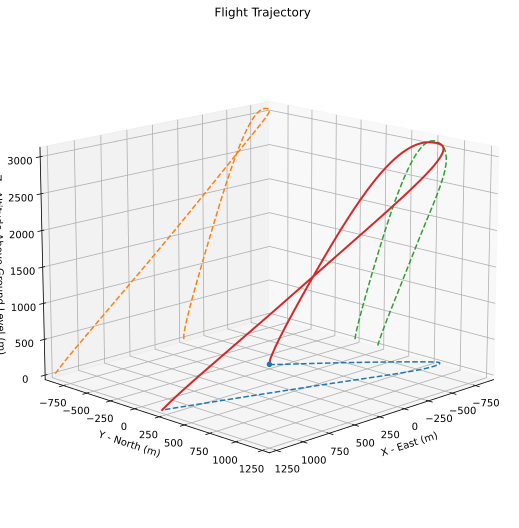



Trajectory Kinematic Plots



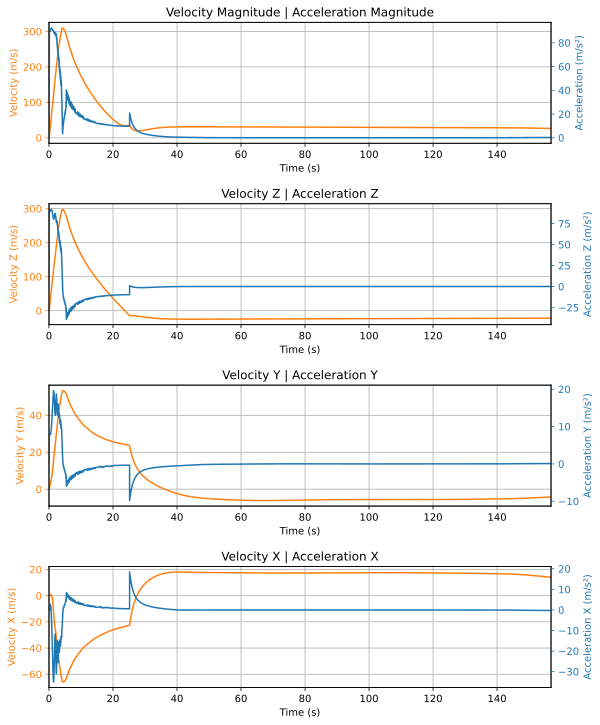



Angular Position Plots



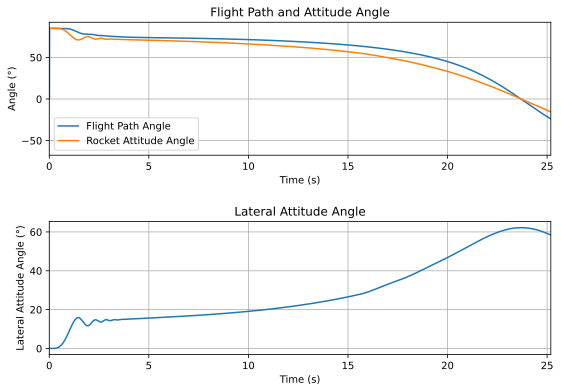



Path, Attitude and Lateral Attitude Angle plots



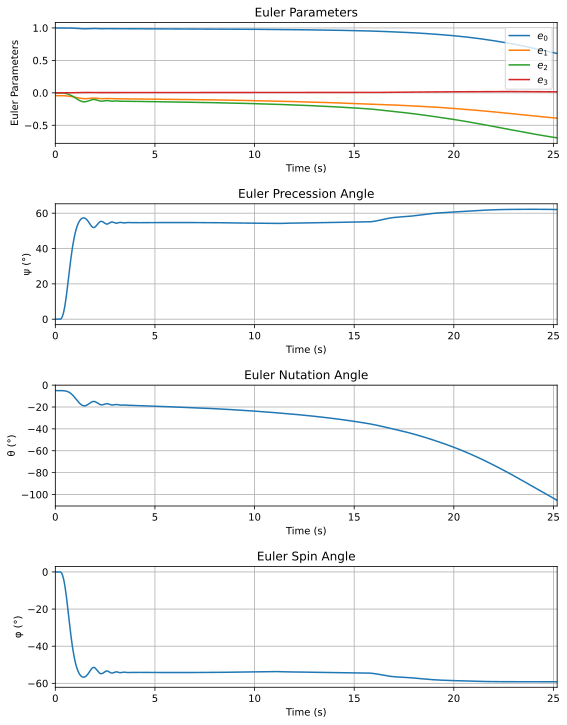



Trajectory Angular Velocity and Acceleration Plots



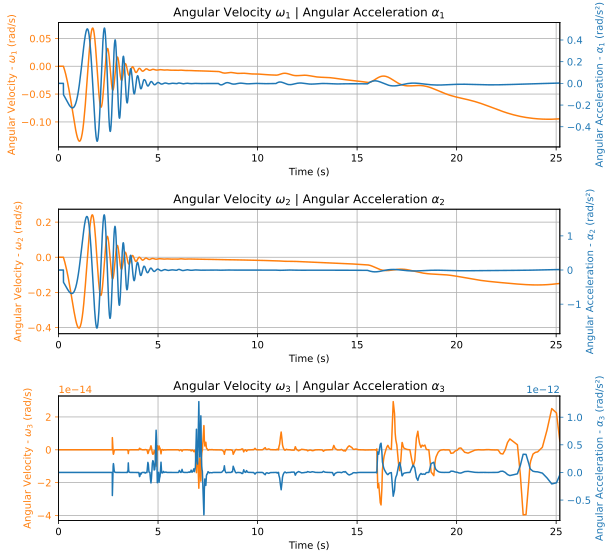



Aerodynamic Forces Plots



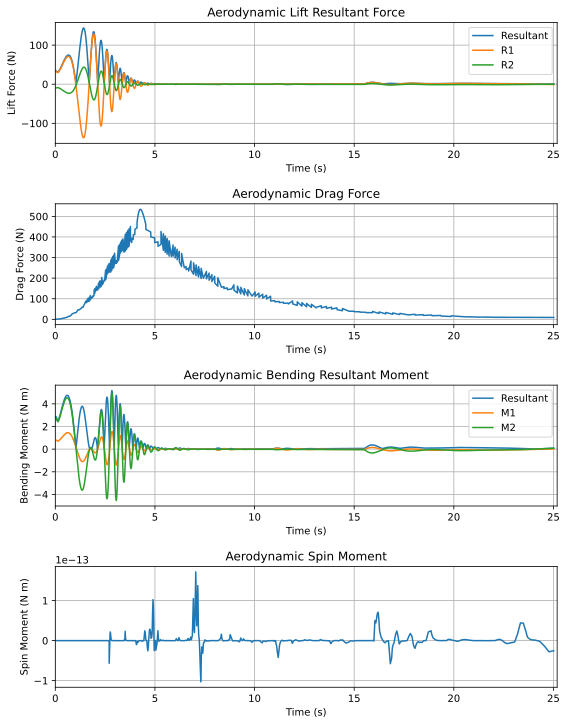



Rail Buttons Forces Plots



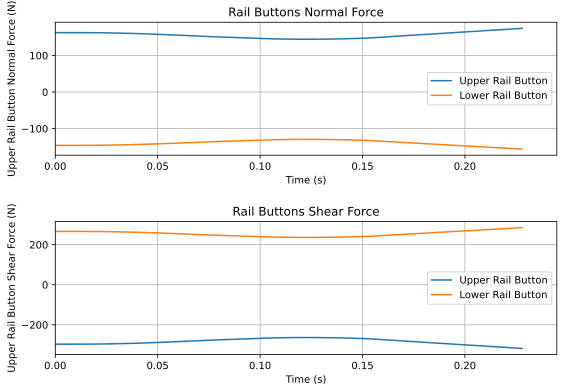



Trajectory Energy Plots



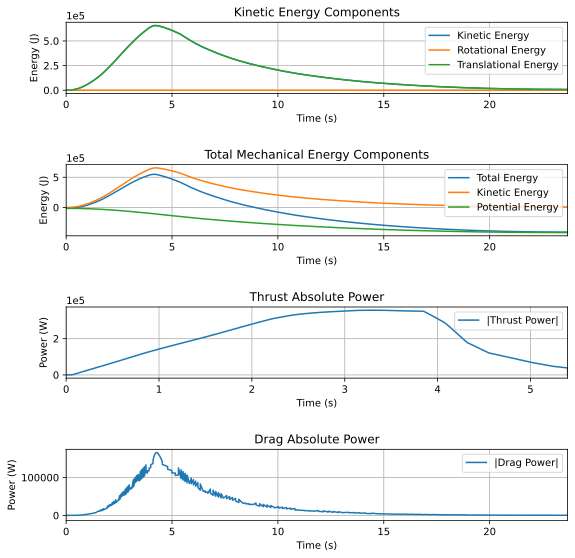



Trajectory Fluid Mechanics Plots



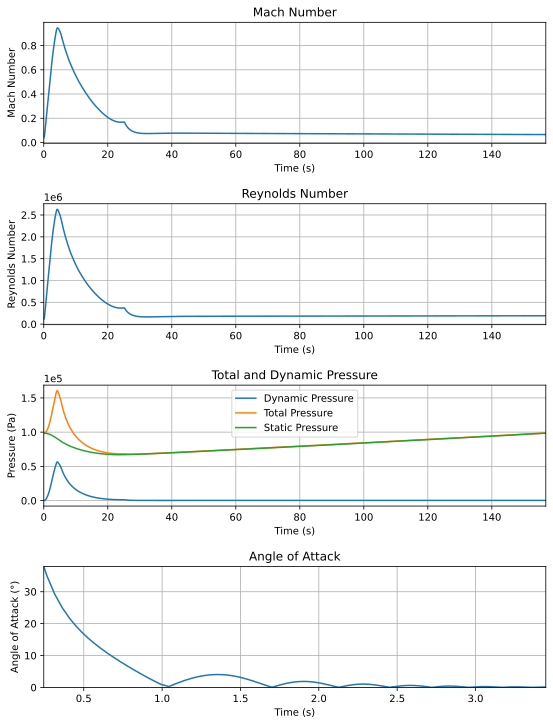



Trajectory Stability and Control Plots



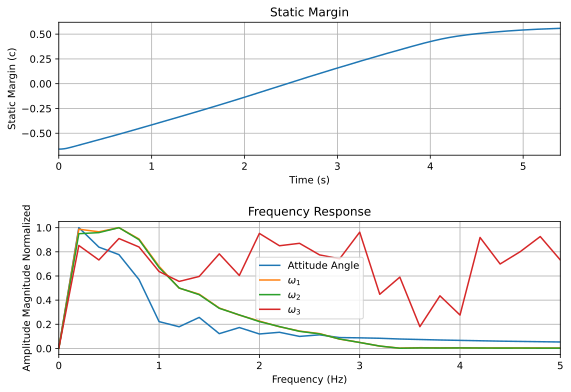



Rocket and Parachute Pressure Plots



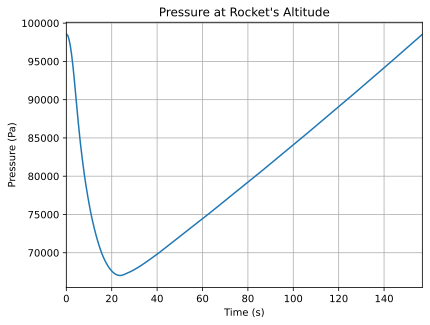


Parachute:  Main


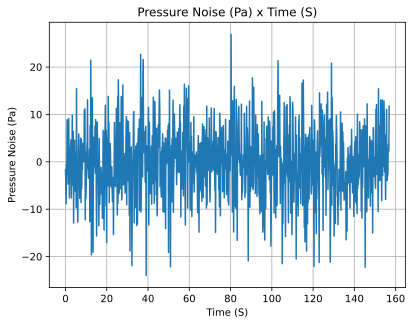

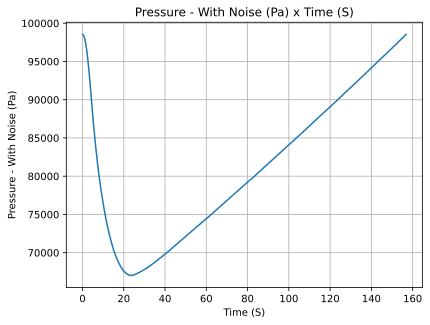

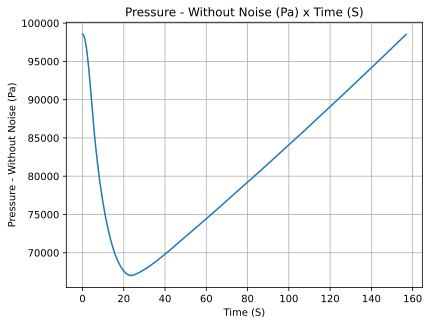


Parachute:  Drogue


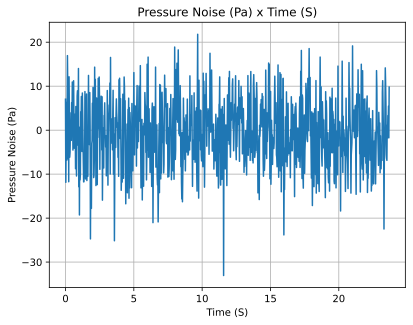

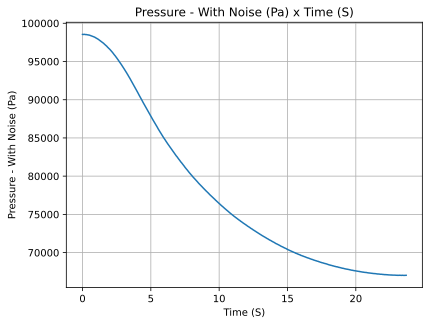

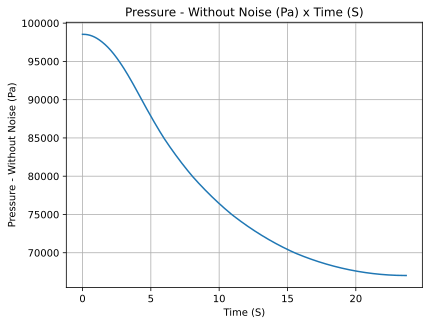

In [17]:
TestFlight.all_info()

Export Flight Trajectory to a .kml file so it can be opened on Google Earth

In [18]:
TestFlight.export_kml(
    file_name="Data/trajectory.kml",
    extrude=True,
    altitude_mode="relativetoground",
)

File  Data/trajectory.kml  saved with success!


Now open up Google earth and Input the new data we simulated!!!

# Ignore bit below this for now

## Using Simulation for Design

Here, we go through a couple of examples which make use of RocketPy in cool ways to help us design our rocket.

### Dynamic Stability Analysis

Ever wondered how static stability translates into dynamic stability? Different static margins result in different dynamic behavior, which also depends on the rocket's rotational inertial.

Let's make use of RocketPy's helper class called Function to explore how the dynamic stability of Saltire varies if we change the fins span by a certain factor.

In [19]:
    # Helper class
from rocketpy import Function

    simulation_results = []
    # Simulate
print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            Saltire.staticMargin(0), Saltire.staticMargin(Saltire.motor.burnOutTime)
      )
    )
TestFlight = Flight(
        rocket=Saltire,
        environment=Env,
        inclination=90,
        heading=0,
        maxTimeStep=0.01,
        maxTime=5,
        terminateOnApogee=True,
        verbose=True,
    )
    # Post process flight data
    TestFlight.postProcess()
    # Store Results
    staticMarginAtIgnition = Saltire.staticMargin(0)
    staticMarginAtOutOfRail = Saltire.staticMargin(TestFlight.outOfRailTime)
    staticMarginAtSteadyState = Saltire.staticMargin(TestFlight.tFinal)
    simulation_results += [
        (
            TestFlight.attitudeAngle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                staticMarginAtIgnition,
                staticMarginAtOutOfRail,
                staticMarginAtSteadyState,
            ),
        )
    ]

Function.comparePlots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

AttributeError: 'Rocket' object has no attribute 'staticMargin'

In [ ]:
# Helper class
from rocketpy import Function

# Prepare Rocket Class
Saltire = Rocket(
    motor=Pro75M1315,
    radius=127 / 2000,
    mass=17.280 - 5.645,
    inertiaI=4.78,
    inertiaZ=0.13,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="/content/drive/MyDrive/Upload/CD Power Off RAS AERO1.csv",
    powerOnDrag="/content/drive/MyDrive/Upload/CD Power On RAS AERO1.csv",
)

Saltire.setRailButtons([0.2, -0.5])
Nose = Saltire.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
FinSet = Saltire.addTrapezoidalFins(
    4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)
Tail = Saltire.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

# Prepare Environment Class
Env = Environment(5.2, 9.8)
Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [0.5, 0.7, 0.9, 1.1, 1.3]:
    # Modify rocket fin set by removing previous one and adding new one
    Saltire.aerodynamicSurfaces.remove(FinSet)
    FinSet = Saltire.addTrapezoidalFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956*factor
)
    # Simulate
    print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            Saltire.staticMargin(0), Saltire.staticMargin(Saltire.motor.burnOutTime)
        )
    )
    TestFlight = Flight(
        rocket=Saltire,
        environment=Env,
        inclination=90,
        heading=0,
        maxTimeStep=0.01,
        maxTime=5,
        terminateOnApogee=True,
        verbose=True,
    )
    # Post process flight data
    TestFlight.postProcess()
    # Store Results
    staticMarginAtIgnition = Saltire.staticMargin(0)
    staticMarginAtOutOfRail = Saltire.staticMargin(TestFlight.outOfRailTime)
    staticMarginAtSteadyState = Saltire.staticMargin(TestFlight.tFinal)
    simulation_results += [
        (
            TestFlight.attitudeAngle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                staticMarginAtIgnition,
                staticMarginAtOutOfRail,
                staticMarginAtSteadyState,
            ),
        )
    ]

Function.comparePlots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

### Characteristic Frequency Calculation

Here we analyse the characteristic frequency of oscillation of our rocket just as it leaves the launch rail. Note that when we ran TestFlight.allInfo(), one of the plots already showed us the frequency spectrum of our flight. Here, however, we have more control of what we are plotting.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

Env = Environment(
    railLength=3, latitude=55.7268113, longitude=-4.8109188, elevation=243
)

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

Env.setAtmosphericModel(type="Forecast", file="GFS")

# Prepare Motor
Pro75M1315 = SolidMotor(
    thrustSource="/content/drive/MyDrive/Upload/AeroTech_M1315W.eng",
    burnOut=5.4,
    grainNumber=5,
    grainSeparation=1.588 / 1000,
    grainDensity=1815,
    grainOuterRadius=34.63 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=129.997 / 1000,
    nozzleRadius=23.8125 / 1000,
    throatRadius=8.699 / 1000,
    interpolationMethod="linear",
)

# Prepare Rocket
Saltire = Rocket(
    motor=Pro75M1315,
    radius=127 / 2000,
    mass=17.280 - 5.645,
    inertiaI=4.78,
    inertiaZ=0.13,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="/content/drive/MyDrive/Upload/CD Power Off RAS AERO1.csv",
    powerOnDrag="/content/drive/MyDrive/Upload/CD Power On RAS AERO1.csv",
)

Saltire.setRailButtons([0.2, -0.5])

Nose = Saltire.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
FinSet = Saltire.addTrapezoidalFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)
Tail = Saltire.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

# Simulate first 5 seconds of Flight
TestFlight = Flight(
    rocket=Saltire,
    environment=Env,
    inclination=90,
    heading=0,
    maxTimeStep=0.01,
    maxTime=5,
)
TestFlight.postProcess()

# Perform a Fourier Analysis
Fs = 100.0
# sampling rate
Ts = 1.0 / Fs
# sampling interval
t = np.arange(1, 400, Ts)  # time vector
ff = 5
# frequency of the signal
y = TestFlight.attitudeAngle(t) - np.mean(TestFlight.attitudeAngle(t))
n = len(y)  # length of the signal
k = np.arange(n)
T = n / Fs
frq = k / T  # two sides frequency range
frq = frq[range(n // 2)]  # one side frequency range
Y = np.fft.fft(y) / n  # fft computing and normalization
Y = Y[range(n // 2)]
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, y)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal")
ax[0].set_xlim((0, 5))
ax[1].plot(frq, abs(Y), "r")  # plotting the spectrum
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("|Y(freq)|")
ax[1].set_xlim((0, 5))
plt.subplots_adjust(hspace=0.5)
plt.show()

### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets heavier.

In [ ]:
import datetime
def apogee(mass):
    # Prepare Environment

    Env = Environment(
      railLength=3, latitude=55.7268113, longitude=-4.8109188, elevation=243
    )

    tomorrow = datetime.date.today() + datetime.timedelta(days=1)

    Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

    Env.setAtmosphericModel(type="Forecast", file="GFS")


    # Prepare Motor
    Pro75M1315 = SolidMotor(
    thrustSource="/content/drive/MyDrive/Upload/AeroTech_M1315W.eng",
    burnOut=5.4,
    grainNumber=5,
    grainSeparation=1.588 / 1000,
    grainDensity=1815,
    grainOuterRadius=34.63 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=129.997 / 1000,
    nozzleRadius=23.8125 / 1000,
    throatRadius=8.699 / 1000,
    interpolationMethod="linear",
)

    # Prepare Rocket
    Saltire = Rocket(
    motor=Pro75M1315,
    radius=127 / 2000,
    mass=mass,
    inertiaI=4.78,
    inertiaZ=0.13,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="/content/drive/MyDrive/Upload/CD Power Off RAS AERO1.csv",
    powerOnDrag="/content/drive/MyDrive/Upload/CD Power On RAS AERO1.csv",
)

    Saltire.setRailButtons([0.2, -0.5])
    Nose = Saltire.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Saltire.addTrapezoidalFins(
        4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
    )
    Tail = Saltire.addTail(
        topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
    )

    # Simulate Flight until Apogee
    TestFlight = Flight(
        rocket=Saltire,
        environment=Env,
        inclination=85,
        heading=0,
        terminateOnApogee=True,
    )
    return TestFlight.apogee


apogeebymass = Function(apogee, inputs="Mass (kg)", outputs="Estimated Apogee (m)")
apogeebymass.plot(8, 20, 20)

### Out of Rail Speed as a Function of Mass

To finish off, lets make a really important plot. Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.

In [ ]:
import datetime
def speed(mass):
    # Prepare Environment

    Env = Environment(
      railLength=3, latitude=55.7268113, longitude=-4.8109188, elevation=243
    )

    tomorrow = datetime.date.today() + datetime.timedelta(days=1)

    Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

    Env.setAtmosphericModel(type="Forecast", file="GFS")

    # Prepare Motor
    Pro75M1315 = SolidMotor(
    thrustSource="/content/drive/MyDrive/Upload/AeroTech_M1315W.eng",
    burnOut=5.4,
    grainNumber=5,
    grainSeparation=1.588 / 1000,
    grainDensity=1815,
    grainOuterRadius=34.63 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=129.997 / 1000,
    nozzleRadius=23.8125 / 1000,
    throatRadius=8.699 / 1000,
    interpolationMethod="linear",
)

    # Prepare Rocket
    Saltire = Rocket(
    motor=Pro75M1315,
    radius=127 / 2000,
    mass=mass,
    inertiaI=4.78,
    inertiaZ=0.13,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="/content/drive/MyDrive/Upload/CD Power Off RAS AERO1.csv",
    powerOnDrag="/content/drive/MyDrive/Upload/CD Power On RAS AERO1.csv",
)

    Saltire.setRailButtons([0.2, -0.5])
    Nose = Saltire.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Saltire.addTrapezoidalFins(
        4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
    )
    Tail = Saltire.addTail(
        topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
    )

    # Simulate Flight until Apogee
    TestFlight = Flight(
        rocket=Saltire,
        environment=Env,
        inclination=85,
        heading=0,
        terminateOnApogee=True,
    )
    return TestFlight.outOfRailVelocity


speedbymass = Function(speed, inputs="Mass (kg)", outputs="Out of Rail Speed (m/s)")
speedbymass.plot(8, 20, 20)

#Monte carlo


In [ ]:
#import relevant packages
from datetime import datetime
from time import process_time, perf_counter, time
import glob

from rocketpy import Environment, SolidMotor, Rocket, Flight, Function

import numpy as np
from numpy.random import normal, uniform, choice
from IPython.display import display

%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14



Put the analysis variables here. From the docs:

We implement this using a dictionary, where the key is the name of the parameter and the value is either a tuple or a list, depending on the behaviour of the parameter: - if the parameter is know, its value is represented as a list with a single entry (i.e. "number_of_fins: [4]") - if the parameter can assume certain discrete values with uniform distribution, its values are represented by a list of possible choices (i.e. "member_of_ensemble_forecast: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]") - if the parameter is best represented by a normal (gaussian) distribution, its value is a tuple with the expected value and its standard deviation (i.e. "rocket_mass": (100, 2), where 100 kg is the expected mass, with uncertainty of plus or minus 2 kg)